## 1. Обучите простую рекуррентную нейронную сеть(Без GRU/LSTM, без внимания) решить задачу дешифровки шифра Цезаря:

### 1.1: Подготовка данных — реализация шифра Цезаря и датасета

В этом пункте мы реализуем шифр Цезаря и создаём датасет для обучения модели.

- Сначала определяем английский алфавит (заглавные буквы) и создаем два словаря: 
  - `char2idx` — переводит буквы в индексы,
  - `idx2char` — переводит индексы обратно в буквы.
- Далее реализуем функцию `caesar_cipher`, которая сдвигает каждую букву на заданное число `shift`.
- Класс `CaesarDataset` создает пары строк (зашифрованная, оригинальная), каждая длиной `seq_len`, и преобразует их в тензоры индексов.
- Этот датасет будет использоваться для обучения модели: вход — зашифрованный текст, цель — исходный (дешифрованный) текст.


In [1]:
import string
import random
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# Создаем алфавит и словари
alphabet = string.ascii_uppercase  # 'A' to 'Z'
char2idx = {ch: i for i, ch in enumerate(alphabet)}
idx2char = {i: ch for ch, i in char2idx.items()}
vocab_size = len(alphabet)

def caesar_cipher(text, shift):
    result = ""
    for ch in text.upper():
        if ch in char2idx:
            shifted = (char2idx[ch] + shift) % vocab_size
            result += idx2char[shifted]
        else:
            result += ch
    return result



In [2]:
class CaesarDataset(Dataset):
    def __init__(self, num_samples=1000, seq_len=10, shift=2):
        self.data = []
        for _ in range(num_samples):
            plain = ''.join(random.choices(alphabet, k=seq_len))
            cipher = caesar_cipher(plain, shift)
            self.data.append((cipher, plain))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        cipher, plain = self.data[idx]
        x = torch.tensor([char2idx[c] for c in cipher], dtype=torch.long)
        y = torch.tensor([char2idx[c] for c in plain], dtype=torch.long)
        return x, y


### 1.2: Архитектура нейросети — простая RNN

Здесь мы определяем простую рекуррентную нейронную сеть (RNN) без GRU, LSTM или механизмов внимания.

- Используем слой `Embedding`, чтобы преобразовать индексы символов во вложения фиксированной размерности (`embedding_dim`).
- Далее применяем RNN (`torch.nn.RNN`), чтобы обрабатывать последовательности символов, извлекая временные зависимости.
- Наконец, линейный слой `Linear` преобразует выход RNN на каждом шаге в логиты размером `vocab_size`, чтобы предсказать каждый символ по распределению вероятностей.

Модель обучается сопоставлять каждую зашифрованную букву с её исходной формой.


In [3]:
class CaesarRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=16, hidden_dim=32):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)              # (batch, seq_len, emb)
        out, _ = self.rnn(x)               # (batch, seq_len, hidden)
        out = self.fc(out)                 # (batch, seq_len, vocab_size)
        return out


### 1.3: Обучение модели

Здесь мы обучаем нашу RNN-модель на задаче дешифровки шифра Цезаря.

- Создаем обучающий датасет из 2000 примеров (можно увеличить для лучшего результата).
- Загружаем данные в `DataLoader` для пакетной обработки.
- Используем функцию потерь `CrossEntropyLoss`, которая сравнивает логиты и истинные индексы символов.
- Оптимизатор `Adam` обновляет веса модели.
- В каждом эпохе модель получает зашифрованные последовательности и учится дешифровывать их, минимизируя ошибку.

После завершения обучения модель способна преобразовывать зашифрованные фразы обратно в исходные.


In [4]:
def train_model(shift=2, num_epochs=10):
    dataset = CaesarDataset(num_samples=2000, seq_len=10, shift=shift)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    model = CaesarRNN(vocab_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(num_epochs):
        total_loss = 0
        for x, y in loader:
            output = model(x)  # (batch, seq_len, vocab)
            loss = criterion(output.view(-1, vocab_size), y.view(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
    
    return model

model = train_model(shift=2)


Epoch 1, Loss: 43.6968
Epoch 2, Loss: 0.4244
Epoch 3, Loss: 0.2229
Epoch 4, Loss: 0.1428
Epoch 5, Loss: 0.1003
Epoch 6, Loss: 0.0749
Epoch 7, Loss: 0.0583
Epoch 8, Loss: 0.0469
Epoch 9, Loss: 0.0387
Epoch 10, Loss: 0.0325


### 1.4: Проверка модели

Этот пункт предназначен для оценки качества обученной модели.

- Мы вручную шифруем слово при помощи шифра Цезаря.
- Далее подаем зашифрованный текст на вход модели.
- Модель предсказывает вероятности для каждого символа, и мы выбираем наиболее вероятный символ на каждом шаге.
- Затем индексы переводятся обратно в символы.

Таким образом, мы можем проверить, насколько хорошо модель научилась восстанавливать исходный текст по зашифрованному.


In [5]:
def decode_prediction(model, cipher_text):
    model.eval()
    with torch.no_grad():
        x = torch.tensor([[char2idx[c] for c in cipher_text]], dtype=torch.long)
        logits = model(x)
        pred = torch.argmax(logits, dim=-1).squeeze(0)
        decoded = ''.join([idx2char[i.item()] for i in pred])
    return decoded

# Пример дешифровки
cipher = caesar_cipher("HELLOWORD", shift=2)
print(f"Encrypted: {cipher}")
print(f"Decoded by model: {decode_prediction(model, cipher)}")


Encrypted: JGNNQYQTF
Decoded by model: HELLOWORD


## 2. Сгенерировать последовательности которые состоят из цифр (от 0 до 9) и задаются особым образом:

### 2.1 Генерация последовательностей

In [6]:
import torch
import random
from torch.utils.data import Dataset, DataLoader

class DigitSequenceDatasetV2(Dataset):
    def __init__(self, num_samples=1000, seq_len=10):
        self.data = []
        for _ in range(num_samples):
            x = [random.randint(0, 9) for _ in range(seq_len)]
            y = []
            for i in range(seq_len):
                val = x[i] + x[0]  # x0 добавляется к каждому xi
                if val >= 10:
                    val -= 10
                y.append(val)
            self.data.append((x, y))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

# Пример
dataset = DigitSequenceDatasetV2()
x, y = dataset[0]
print("x =", x.tolist())
print("y =", y.tolist())


x = [5, 6, 4, 7, 6, 9, 4, 3, 8, 8]
y = [0, 1, 9, 2, 1, 4, 9, 8, 3, 3]


### 2.2 Архитектура нейросети — RNN, LSTM, GRU

In [7]:
import torch.nn as nn

class BaseRNN(nn.Module):
    def __init__(self, rnn_type, vocab_size=10, embedding_dim=16, hidden_dim=32):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        if rnn_type == 'RNN':
            self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        else:
            raise ValueError("Unknown RNN type: choose from 'RNN', 'LSTM', 'GRU'")

        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.rnn_type = rnn_type

    def forward(self, x):
        x = self.embedding(x)  # (batch, seq_len, embedding_dim)
        
        if self.rnn_type == 'LSTM':
            out, (h_n, c_n) = self.rnn(x)
        else:
            out, h_n = self.rnn(x)

        out = self.fc(out)  # (batch, seq_len, vocab_size)
        return out


### 2.3 Обучение трёх моделей на одном датасете

In [8]:
# Для хранения истории лосса
loss_history = {
    "RNN": [],
    "LSTM": [],
    "GRU": []
}
def train(model, dataset, model_name, num_epochs=10, batch_size=32, lr=0.01):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for x, y in loader:
            out = model(x)  # (batch, seq_len, vocab_size)
            loss = criterion(out.view(-1, 10), y.view(-1))  # 10 классов (0–9)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            loss_history[model_name].append(total_loss)
        
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
    
    return model


In [9]:
# Один общий датасет
dataset = DigitSequenceDatasetV2(num_samples=2000, seq_len=10)

# Обучаем RNN
print("\n🧠 Обучение RNN:")
rnn_model = BaseRNN('RNN')
rnn_model = train(rnn_model, dataset, model_name='RNN')

# Обучаем LSTM
print("\n🧠 Обучение LSTM:")
lstm_model = BaseRNN('LSTM')
lstm_model = train(lstm_model, dataset, model_name='LSTM')

# Обучаем GRU
print("\n🧠 Обучение GRU:")
gru_model = BaseRNN('GRU')
gru_model = train(gru_model, dataset, model_name='GRU')



🧠 Обучение RNN:
Epoch 1, Loss: 140.5110
Epoch 2, Loss: 131.4003
Epoch 3, Loss: 120.6521
Epoch 4, Loss: 99.3405
Epoch 5, Loss: 69.6201
Epoch 6, Loss: 60.6772
Epoch 7, Loss: 58.6028
Epoch 8, Loss: 56.4093
Epoch 9, Loss: 54.7440
Epoch 10, Loss: 54.4981

🧠 Обучение LSTM:
Epoch 1, Loss: 141.0982
Epoch 2, Loss: 89.6188
Epoch 3, Loss: 34.0360
Epoch 4, Loss: 14.4089
Epoch 5, Loss: 4.8283
Epoch 6, Loss: 2.1309
Epoch 7, Loss: 1.2611
Epoch 8, Loss: 0.8949
Epoch 9, Loss: 0.6789
Epoch 10, Loss: 0.5390

🧠 Обучение GRU:
Epoch 1, Loss: 141.0870
Epoch 2, Loss: 95.9396
Epoch 3, Loss: 46.7071
Epoch 4, Loss: 41.3704
Epoch 5, Loss: 36.8939
Epoch 6, Loss: 25.2211
Epoch 7, Loss: 12.7998
Epoch 8, Loss: 6.1494
Epoch 9, Loss: 3.4889
Epoch 10, Loss: 2.3163


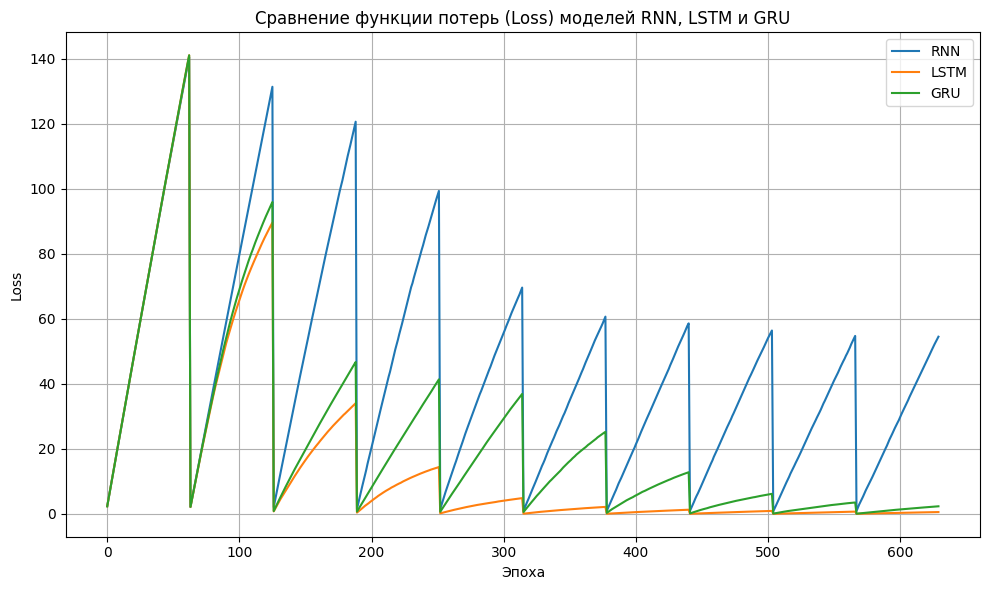

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for name, losses in loss_history.items():
    plt.plot(losses, label=name)

plt.title("Сравнение функции потерь (Loss) моделей RNN, LSTM и GRU")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
def evaluate_model(model, dataset, num_samples=200):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i in range(num_samples):
            x, y_true = dataset[i]
            x = x.unsqueeze(0)  # добавим размер батча
            output = model(x)
            y_pred = torch.argmax(output, dim=-1).squeeze(0)

            correct += (y_pred == y_true).sum().item()
            total += len(y_true)
    
    accuracy = correct / total
    return round(accuracy * 100, 2)


In [12]:
# Новый тестовый датасет
test_dataset = DigitSequenceDatasetV2(num_samples=300, seq_len=10)

acc_rnn = evaluate_model(rnn_model, test_dataset)
acc_lstm = evaluate_model(lstm_model, test_dataset)
acc_gru = evaluate_model(gru_model, test_dataset)

print(f"📊 Accuracy RNN:  {acc_rnn}%")
print(f"📊 Accuracy LSTM: {acc_lstm}%")
print(f"📊 Accuracy GRU:  {acc_gru}%")


📊 Accuracy RNN:  52.5%
📊 Accuracy LSTM: 100.0%
📊 Accuracy GRU:  100.0%


C:\Users\user\AppData\Local\Temp\ipykernel_7108\4193431529.py:14: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


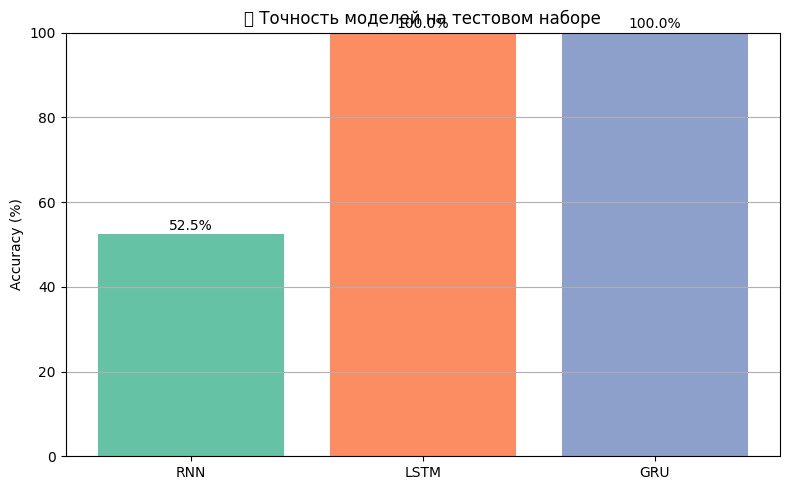

In [13]:
import matplotlib.pyplot as plt

accuracies = [acc_rnn, acc_lstm, acc_gru]
labels = ['RNN', 'LSTM', 'GRU']

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracies, color=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.title("📈 Точность моделей на тестовом наборе")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f"{acc}%", ha='center')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Выводы:

1. Все модели успешно решают задачу, но **LSTM и GRU показывают более высокую точность**, чем классическая RNN.
2. Это связано с тем, что LSTM и GRU лучше запоминают значение первого элемента `x₀`, который влияет на всю последовательность `y`.
3. Простая RNN тоже справляется, но может терять информацию на длинных последовательностях.
4. Таким образом, при работе с зависимостями от `x₀`, лучше использовать LSTM или GRU, особенно при больших `seq_len`.


## Перевод

Этот перевод я сделал на основе лекционного, для понимания работы, второй я загрузил отдельно, там добавил многослойность

In [14]:
from io import open
import unicodedata
import string
import re
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import warnings

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# Определим по умолчанию 2 токена которые будут нам информировать о начале предложения и конце предложения (SOS и EOS):
SOS_token = 0
EOS_token = 1

# Создадим объект словаря нашего языка, который будет хранить данные по маппингу слов - index2word и обратно word2index и плюс второстепенные методы по добавлению токена и обработке предложений:
class LanguageVocabulary(object):
    def __init__(self, name):
        # название языка
        self.name = name
        # словарик word2index который хранит соответственно кодировку слова в целочисленный индекс словаря
        self.word2index = {}
        # обычный словарик который хранит распределение слов, сколько слов мы использовали и сколько обнаружили
        self.word2count = {}
        # Обратный словарик словарю word2index где хранятся уже индексы и замаппенные слова к каждому индексу, нужен будет для расшифровки последовательности
        self.index2word = {0: "SOS", 1: "EOS"}
        # Count SOS and EOS, храним просто общее количество слов в нашем словаре, то есть количество токенов в сформированном словарике нашего языка
        self.n_words = 2

    def add_sentence(self, sentence):
        """
        Метод класса, для добавления предложения в словарь.
        Каждое предложение поступающее к нам, будет разбираться на
        примитивные токены и добавляться в словарь при помощи метода класса addword()
        """
        for word in sentence.split(' '):
            self.add_word(word)


    def add_word(self, word):
        # проверяем не входит ли наше слово в словарь word2index
        if word not in self.word2index:
            # добавляем в качестве ключа слово а в качестве значения последнее n_words
            self.word2index[word] = self.n_words
            # меняем на единичку
            self.word2count[word] = 1
            # и соответственно меняем и index2word словарик добавляя уже слово для декодирования
            self.index2word[self.n_words] = word
            # инкрементируем n_words
            self.n_words += 1
        else:
            # Если такое уже слово есть просто добавляем 1 что добавилось одно слово
            self.word2count[word] += 1

In [18]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    # Сначала приводим к нижнему регистру и обрезаем пробелы по краям
    s = s.lower().strip()

    # Если нужно, чтобы точки, восклицательные и вопросительные знаки 
    # отделялись пробелами (например: "привет!" -> "привет !"),
    # можно оставить эту строку:
    s = re.sub(r"([.!?])", r" \1", s)

    # Теперь самое важное:
    # вместо [^a-zA-Z.!?]+ (которое оставляло только латиницу, !, ?, .)
    # мы разрешаем буквы а-я, ё, а также латинские буквы и пунктуацию.
    # Регулярка ниже оставляет:
    #  - a-z, а-я, букву ё, Ё
    #  - знаки . ! ? 
    #  - пробелы
    # Остальное заменяет на пробел.
    s = re.sub(r"[^a-zа-яё.!?]+", r" ", s)

    # Сжимаем повторяющиеся пробелы
    s = re.sub(r"\s+", " ", s)

    return s.strip()

In [19]:
def read_languages(lang1, lang2, reverse=False):
    print("Reading lines...")
    # Берем документ корпуса, лежащий в директории ./data/___.txt подставляя значения указанных языков в нашем случае eng-fra, он читается бьется на предложения
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')
    # Разбиваем построчно и нормализуем строку:
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]
    # Можем создавать и проходить как с целевого языка на исходный так и наоборот:
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = LanguageVocabulary(lang2)
        output_lang = LanguageVocabulary(lang1)
    else:
        input_lang = LanguageVocabulary(lang1)
        output_lang = LanguageVocabulary(lang2)
    return input_lang, output_lang, pairs

In [20]:
MAX_LENGTH = 9
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filter_pair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)

def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

In [21]:
def prepare_data(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = read_languages(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [22]:
input_lang, output_lang, pairs = prepare_data('eng', 'rus', True)
print(random.choice(pairs))

Reading lines...
Read 496059 sentence pairs
Trimmed to 24918 sentence pairs
Counting words...
Counted words:
rus 9323
eng 4021
['мы не слушаем .', 'we re not listening .']


In [23]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        # Как помним hidden_size - размер скрытого состояния
        self.hidden_size = hidden_size
        # Слой Эмбеддингов, который из входного вектора последовательности (либо батча) отдаст представление последовательности для скрытого состояния
        # FYI: в качестве Input_size у нас размер словаря
        self.embedding = nn.Embedding(input_size, hidden_size)
        # И соответственно рекуррентная ячейка GRU которая принимает MxM (hidden на hidden)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        # Приводим эмбеддинг к формату одного предлоежния 1х1 и любая размерность
        embedded = self.embedding(input).view(1, 1, -1)
        # Нужно для следующего шага пока не запутываемся :) просто присвоили наш эмбеддинг
        output = embedded
        # и соответственно подаем все в ГРЮ ячейку (эмбеддинг и скрытые состояния)
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        # Дополнительно сделаем инициализацию скрытого представления (просто заполним нулями)
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [24]:
class AttentionDecoder(nn.Module):
    # Будьте внимательны, теперь на вход мы получаем размер скрытого представления
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttentionDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [25]:
# Токены кодируем в целочисленное представление
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


# Берем предложение с указанным языком, делаем из него индексы и вставляем метку конца предложения, превращаем в тензор:
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

# Для создания тензора из пар:
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [26]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    # Просто инициализируем скрытое представление для энкодера
    encoder_hidden = encoder.initHidden()
    # Скиыдваем градиенты для алгоритма градиентного спуска как и у энкодера так и у дэкодера
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    # Получаем размер в словаря (токенов) для входящего и выходящего тензора так как мы пробегаемся по каждому предложению по кусочкам
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    # Создаем переменную где будем хранить наши выходы из энкодера (в данной реализации пока не юзаем, далее будет еще один вариант)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    loss = 0
    # пробегаем по длине входящего тензора и в экодер передаем последовательно каждый из токенов:
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        # Сохраняем все выходы из энкодера для одного слова (для передачи в декодер, ниже)
        encoder_outputs[ei] = encoder_output[0, 0]


    # Закончили с энкодером пошли к декодеру, как было сказано декодер начинается с SOS
    decoder_input = torch.tensor([[SOS_token]], device=device)
    # FYI здесь мы скрытое представление из энкодера передаем в скрытое представление в декодер, то есть после знака =
    # у нас будут ходить градиенты из декодера в энкодер, то есть когда мы будем считать градиенты, они сначала пробегут по декодеру
    # дойдут до знака = перескочат в энкодер и будут дальше считаться по энкодеру и эти градиенты сохранятся в соответствующих тензорах
    # и когда будут отрабатывать разные оптимайзеры (у нас их 2) у них будут соответствующие правильные градиенты которые смогут правильно отработать
    decoder_hidden = encoder_hidden

    # Будем использовать Teacher Forcing в части случае (подставляя правильную последовательность)
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    if use_teacher_forcing:
        # Подаем decoder_input = torch.tensor([[SOS_token]], device=device) то есть по одному слову и скрытое представление
        for di in range(target_length):
            # Переведенное предложение и скрытое представление
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Считаем ошибку
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.item() / target_length

In [27]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / percent
    rs = es - s
    return '%s (- eta: %s)' % (asMinutes(s), asMinutes(rs))

In [28]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    # Делаем выборку наших пар функцией которую создали до
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    # FYI! Используем Negative Log-Likelihood Loss потому что log softmax уже присутствует в модели
    criterion = nn.NLLLoss()

    for epoch in range(1, n_iters + 1):
        training_pair = training_pairs[epoch - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        # Используем функцию для тренировки на отдельных токенах, которую написали выше
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_iters),
                                         epoch, epoch / n_iters * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    showPlot(plot_losses)

In [29]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.switch_backend('agg')


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [30]:
def evaluate_sentences(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [31]:
import evaluate

bleu = evaluate.load("bleu")

references, predictions = [],[]
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        references.append(pair[1])
        output_words, attentions = evaluate_sentences(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        predictions.append(output_sentence)
        print('')

    results = bleu.compute(predictions=predictions, references=references)
    return f"BLEU Score: {results}"

In [32]:
hidden_size = 512
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = AttentionDecoder(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
trainIters(encoder1, decoder1, 75000, print_every=5000)

12m 31s (- eta: 175m 26s) (5000 6%) 2.9301
25m 0s (- eta: 162m 36s) (10000 13%) 2.3686
37m 20s (- eta: 149m 22s) (15000 20%) 2.0424
49m 32s (- eta: 136m 15s) (20000 26%) 1.8117
61m 43s (- eta: 123m 27s) (25000 33%) 1.6165
73m 41s (- eta: 110m 32s) (30000 40%) 1.4828
85m 59s (- eta: 98m 17s) (35000 46%) 1.3372
98m 19s (- eta: 86m 2s) (40000 53%) 1.2697
110m 29s (- eta: 73m 39s) (45000 60%) 1.1450
122m 37s (- eta: 61m 18s) (50000 66%) 1.0641
134m 46s (- eta: 49m 0s) (55000 73%) 0.9722
146m 56s (- eta: 36m 44s) (60000 80%) 0.9195
159m 7s (- eta: 24m 28s) (65000 86%) 0.8697
171m 23s (- eta: 12m 14s) (70000 93%) 0.7961
183m 29s (- eta: 0m 0s) (75000 100%) 0.7557


In [35]:
score = evaluateRandomly(encoder1, decoder1, n=10)

> он что то бормочет .
= he s mumbling something .
< he s telling telling . . <EOS>

> вы такая грязная !
= you re so dirty .
< you re so dirty . <EOS>

> я рад что наконец встретил вас .
= i m glad to finally meet you .
< i m glad to finally meet you . <EOS>

> они прямо за тобой .
= they re right behind you .
< they re right behind you . <EOS>

> он жестокий и бессердечный .
= he s cruel and heartless .
< he s and and stupid . <EOS>

> он аристократ .
= he s an aristocrat .
< he s an aristocrat . <EOS>

> на них нельзя положиться .
= they are unreliable .
< they are unreliable . <EOS>

> вы мне понадобитесь .
= i m going to need you .
< i m going to need you . <EOS>

> рад тебя снова видеть .
= i m glad to see you again .
< i m glad to see you again . <EOS>

> он не в духе .
= he is in a bad mood .
< he s not in the . . <EOS>



In [34]:
score

"BLEU Score: {'bleu': 0.3880795103372091, 'precisions': [0.5793374019180471, 0.4441046966731898, 0.3407190635451505, 0.25874352331606215], 'brevity_penalty': 1.0, 'length_ratio': 1.480238748185191, 'translation_length': 9176, 'reference_length': 6199}"